##EXTRACTING DATASET

In [1]:
from google.colab import files
import zipfile
import os


# Define extraction path and extract the zip file
zip_file_path = "cardiodataset.zip"  # Replace with the uploaded .zip filename
extract_to_path = "/content/dataset"  # Destination folder for extracted files

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("Dataset extracted to:", extract_to_path)

Dataset extracted to: /content/dataset


# Check Number of Images

In [3]:
import os
import shutil
dataset_path = '/content/dataset'
for dirpath, dirname, filename in os.walk(dataset_path):
    print(f"Directory: {dirpath}, Subdirectories: {len(dirname)}, Files: {len(filename)}")


Directory: /content/dataset, Subdirectories: 4, Files: 0
Directory: /content/dataset/ECG Images of Patient that have History of MI (172x12=2064), Subdirectories: 0, Files: 172
Directory: /content/dataset/ECG Images of Myocardial Infarction Patients (240x12=2880), Subdirectories: 0, Files: 239
Directory: /content/dataset/ECG Images of Patient that have abnormal heartbeat (233x12=2796), Subdirectories: 0, Files: 233
Directory: /content/dataset/Normal Person ECG Images (284x12=3408), Subdirectories: 0, Files: 284


# Visualize Images

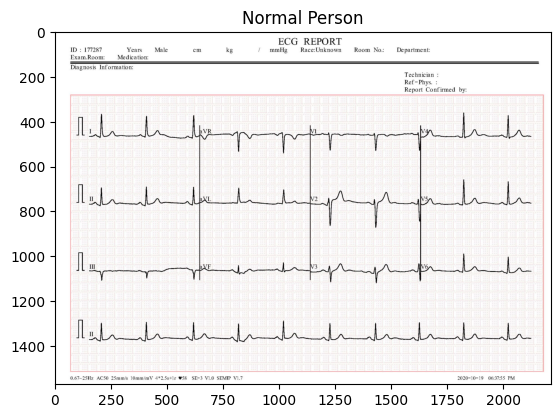

In [4]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

def img_show(img_path, title):
    img = cv2.imread(img_path)[:,:,::-1]
    plt.imshow(img)
    plt.title(title)
    plt.show()

img_show('/content/dataset/Normal Person ECG Images (284x12=3408)/Normal(103).jpg', 'Normal Person')


 # Data Augmentation

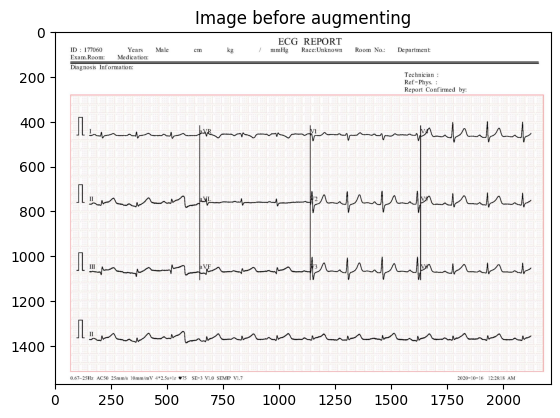

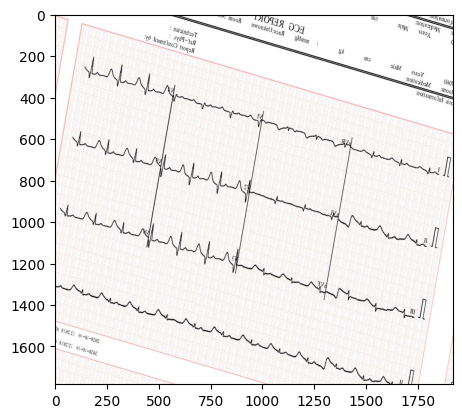

In [5]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")

# Test the augmentation layer
path = "/content/dataset/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(103).jpg"
img_show(path, "Image before augmenting")
img = cv2.imread(path)
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze((augmented_img)/255.)[:, :, ::-1]

plt.figure()
plt.imshow(augmented_img)
plt.show()


# Split Data

In [9]:
import os
import shutil
import math

# Define base paths for train, validation, and test folders
base_path = "/content/dataset"
train_folder = os.path.join(base_path, "train")
validation_folder = os.path.join(base_path, "validation")
test_folder = os.path.join(base_path, "test")

# Original data paths
class_dirs = {
    "MI_history": "ECG Images of Patient that have History of MI (172x12=2064)",  # Corrected folder name
    "MI_patients": "ECG Images of Myocardial Infarction Patients (240x12=2880)",
    "abnormal_heartbeat": "ECG Images of Patient that have abnormal heartbeat (233x12=2796)",
    "normal": "Normal Person ECG Images (284x12=3408)"
}

# Create directories for each split and each class
for folder in [train_folder, validation_folder, test_folder]:
    for cls in class_dirs.keys():
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# Copy files into split folders
def split_and_copy(src_folder, dst_folder, filenames):
    for filename in filenames:
        src_path = os.path.join(src_folder, filename)
        dst_path = os.path.join(dst_folder, filename)
        shutil.copy(src_path, dst_path)

# Loop over each class directory and split files
for cls, cls_dir in class_dirs.items():
    src_class_folder = os.path.join(base_path, cls_dir)
    filenames = sorted(os.listdir(src_class_folder))  # List all files in directory

    # Calculate split sizes
    total_files = len(filenames)
    train_size = math.ceil(total_files * 0.7)
    val_size = math.ceil(total_files * 0.15)
    test_size = total_files - train_size - val_size  # Remaining for test

    # Shuffle filenames for randomness
    filenames = sorted(filenames)  # Add random.shuffle(filenames) here if required

    # Split file lists
    train_files = filenames[:train_size]
    val_files = filenames[train_size:train_size + val_size]
    test_files = filenames[train_size + val_size:]

    # Copy files to respective folders
    split_and_copy(src_class_folder, os.path.join(train_folder, cls), train_files)
    split_and_copy(src_class_folder, os.path.join(validation_folder, cls), val_files)
    split_and_copy(src_class_folder, os.path.join(test_folder, cls), test_files)

print("Data split into train, validation, and test sets successfully.")



Data split into train, validation, and test sets successfully.


###Data Preprocessing

In [11]:
import tensorflow as tf
import os

# Define paths
base_path = "/content/dataset"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "validation")
test_dir = os.path.join(base_path, "test")

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Load the datasets with image preprocessing
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

# Class names for reference
print("Classes:", train_data.class_names)

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

# Rescaling layer to normalize pixel values
rescale = tf.keras.layers.Rescaling(1./255)

# Apply preprocessing: augmentation for train data only
train_data = train_data.map(lambda x, y: (rescale(data_augmentation(x)), y))
val_data = val_data.map(lambda x, y: (rescale(x), y))
test_data = test_data.map(lambda x, y: (rescale(x), y))

# Optimizing data loading performance with prefetching
train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Data preprocessing is complete.")


Found 652 files belonging to 4 classes.
Found 140 files belonging to 4 classes.
Found 136 files belonging to 4 classes.
Classes: ['MI_history', 'MI_patients', 'abnormal_heartbeat', 'normal']
Data preprocessing is complete.


###Model Building

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 with pre-trained weights
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze lower VGG16 layers, unfreeze top layers for fine-tuning
for layer in vgg.layers[:-4]:  # Unfreeze top 4 layers (adjustable based on model performance)
    layer.trainable = False

# Build the model on top of VGG16 base
x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # Binary output for cardiovascular disease prediction

# Compile the model
model = Model(inputs=vgg.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Lower LR for fine-tuning

# Print model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,692,612 (105.64 MB)

 Trainable params: 20,057,348 (76.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

###Train and Save the Model

In [17]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define paths for data and model save
train_path = os.path.join(base_path, "train")
validation_path = os.path.join(base_path, "validation")
model_save_path = os.path.join(base_path, "model/vgg16_cardiovascular_model.keras")

# Data augmentation and rescaling for train and validation data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load data with data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)

# Compile the model (if not already compiled)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Save the model manually in case checkpoint didn't trigger
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Found 652 images belonging to 4 classes.
Found 140 images belonging to 4 classes.
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7112 - loss: 0.7608
Epoch 1: val_loss improved from inf to 1.19530, saving model to /content/dataset/model/vgg16_cardiovascular_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 853ms/step - accuracy: 0.7118 - loss: 0.7587 - val_accuracy: 0.6643 - val_loss: 1.1953
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6974 - loss: 0.7414
Epoch 2: val_loss improved from 1.19530 to 0.72124, saving model to /content/dataset/model/vgg16_cardiovascular_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 584ms/step - accuracy: 0.6974 - loss: 0.7422 - val_accuracy: 0.7643 - val_loss: 0.7212
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7304 - loss: 0.6840
Epoch 3: val_loss did not improve from 0.72124
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 507ms/step - accuracy: 0.7305 - loss: 0.6832 - val_accuracy: 0.6643 - val_loss: 0.8125
Epoch 4/50
41/4

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the model
model_path = os.path.join(base_path, "model/vgg16_cardiovascular_model.keras")
model = load_model(model_path)

# Predict function
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    prediction = model.predict(img_data)
    index = ['MI_history', 'MI_patients', 'abnormal_heartbeat', 'normal']
   # Retrieve the class with the highest probability
    predicted_class = class_labels[np.argmax(prediction[0])]
    return predicted_class

# Test the prediction function
test_img_path = '/content/dataset/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(101).jpg'
result = predict_image(test_img_path)
print(f"Prediction for the test image: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Prediction for the test image: abnormal_heartbeat


###Load the Model and Predict , confusion matrix , classification report

Found 136 images belonging to 4 classes.


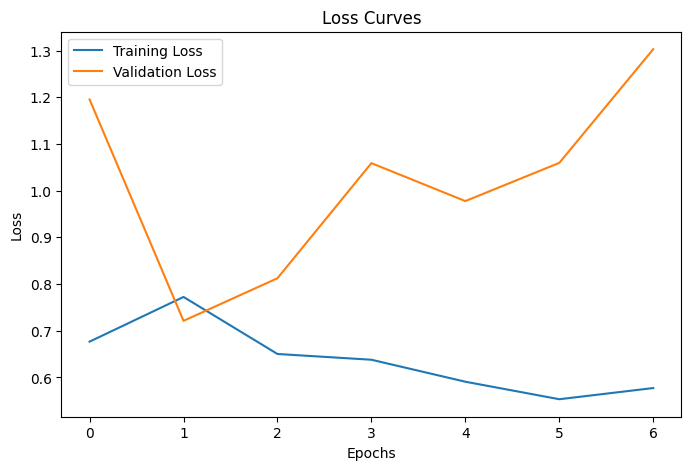

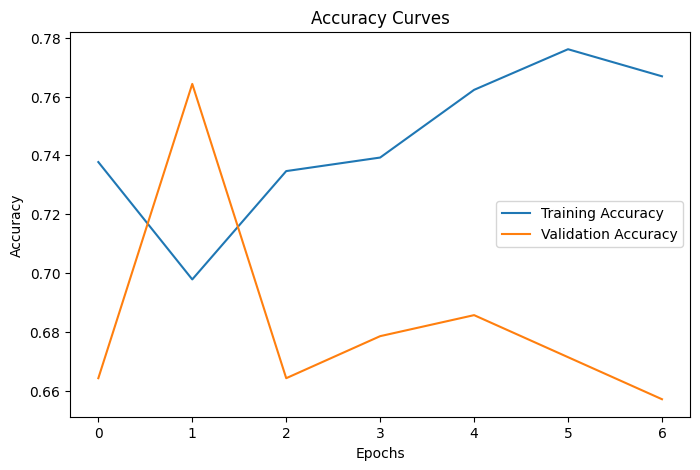

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 929ms/step - accuracy: 0.5550 - loss: 0.8377
Test Loss: 0.6451048851013184
Test Accuracy: 0.7573529481887817
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step
Classification Report
                    precision    recall  f1-score   support

        MI_history       0.00      0.00      0.00        25
       MI_patients       0.92      0.97      0.94        35
abnormal_heartbeat       0.94      0.85      0.89        34
            normal       0.59      0.95      0.73        42

          accuracy                           0.76       136
         macro avg       0.61      0.69      0.64       136
      weighted avg       0.65      0.76      0.69       136

Confusion Matrix:
[[ 0  1  2 22]
 [ 0 34  0  1]
 [ 0  0 29  5]
 [ 0  2  0 40]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_path = os.path.join(base_path, "test")
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Plotting loss and accuracy curves
def plot_loss_curves(history):
    # Loss Curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy Curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss_curves(history)

# Model evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report and confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Adjusting predictions if they are not binary
if len(y_pred.shape) > 1:
    y_pred = y_pred[:, 0]

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['MI_history', 'MI_patients', 'abnormal_heartbeat', 'normal']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
'''plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cataract'], yticklabels=['Normal', 'Cataract'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''
print('Confusion Matrix:')
print(cm)